# Joint Image & Text Embeddings

This example shows how SentenceTransformer can be used to map images and texts to the same vector space. 

As model, we use the [OpenAI CLIP Model](https://github.com/openai/CLIP), which was trained on a large set of images and image alt texts.

As a source for fotos, we use the [Unsplash Dataset Lite](https://unsplash.com/data), which contains about 25k images. See the [License](https://unsplash.com/license) about the Unsplash images. 

Note: 25k images is rather small. If you search for really specific terms, the chance are high that no such photo exist in the collection.

In [1]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
torch.set_num_threads(4)



#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')


/Users/lprone/Documents/test/venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/lprone/Documents/test/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
# Next, we get about 25k images from Unsplash 
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)
        

In [3]:
# Now, we need to compute the embeddings
# To speed things up, we distribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings: 
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)
        
    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))
else:
    img_names = list(glob.glob('unsplash/photos/*.jpg'))
    print("Images:", len(img_names))
    img_emb = model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)


Images: 24996


In [4]:
# Next, we define a search function.
def search(query, k=3):
    # First, we encode the query (which can either be an image or a text string)
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    
    # Then, we use the util.semantic_search function, which computes the cosine-similarity
    # between the query embedding and all image embeddings.
    # It then returns the top_k highest ranked images, which we output
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    
    print("Query:")
    display(query)
    for hit in hits:
        print(img_names[hit['corpus_id']])
        display(IPImage(os.path.join(img_folder, img_names[hit['corpus_id']]), width=200))


Query:


'Two dogs playing in the snow'

FAcSe7SjDUU.jpg


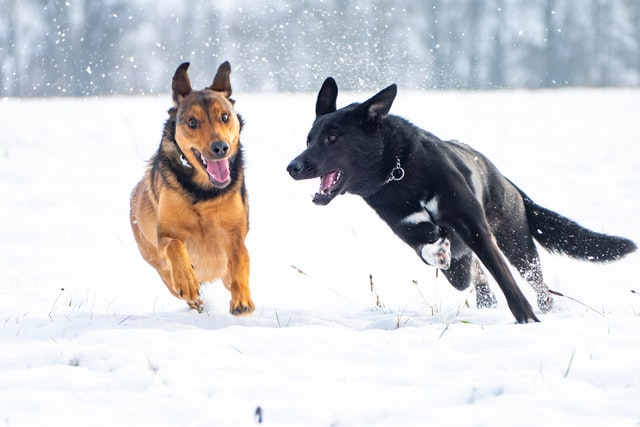

lyStEjlKNSw.jpg


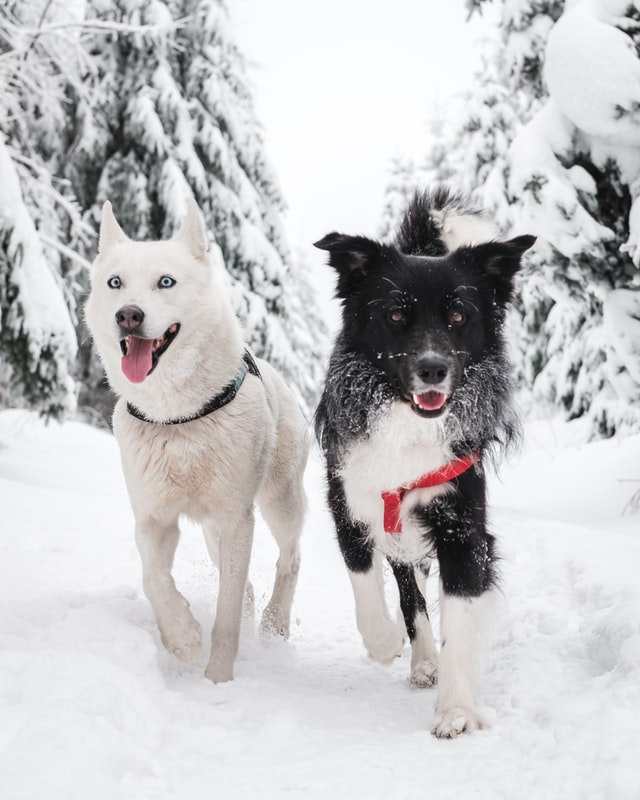

Hb6nGDgWztE.jpg


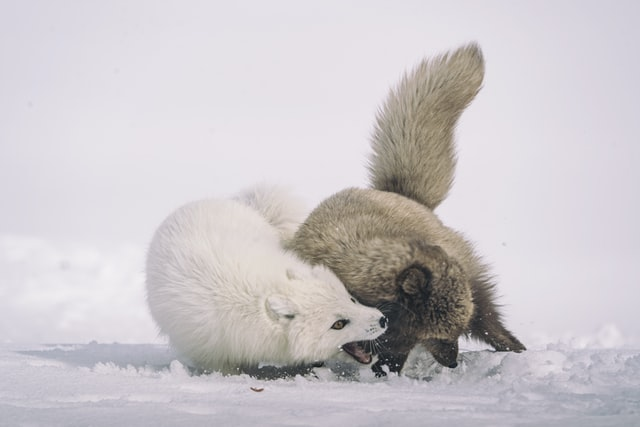

In [5]:
search("Two dogs playing in the snow")

Query:


'A sunset on the beach'

nfQ2QGhdQNc.jpg


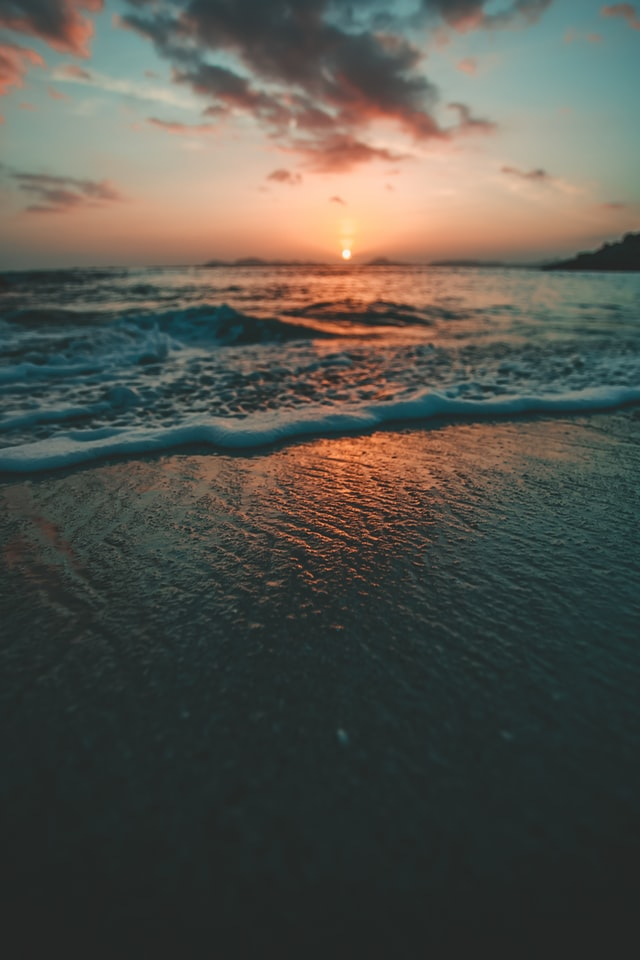

JC5U3Eyiyr4.jpg


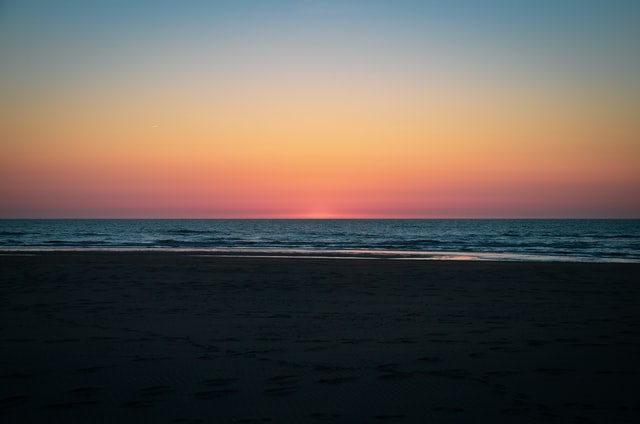

vlukOqxOA8o.jpg


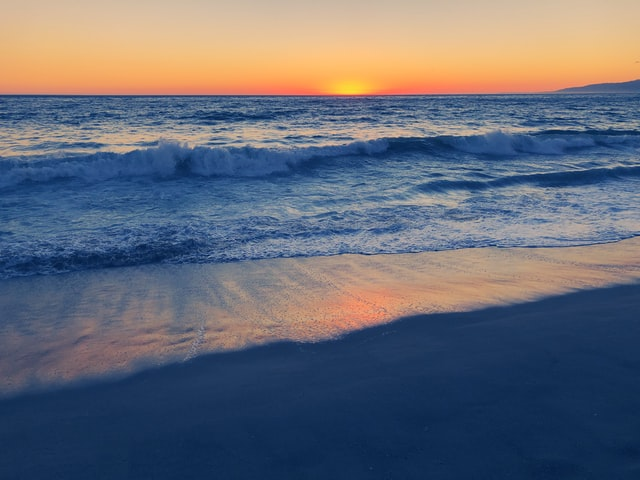

In [6]:
search("A sunset on the beach")

Query:


'London'

UnGcRvTyJOo.jpg


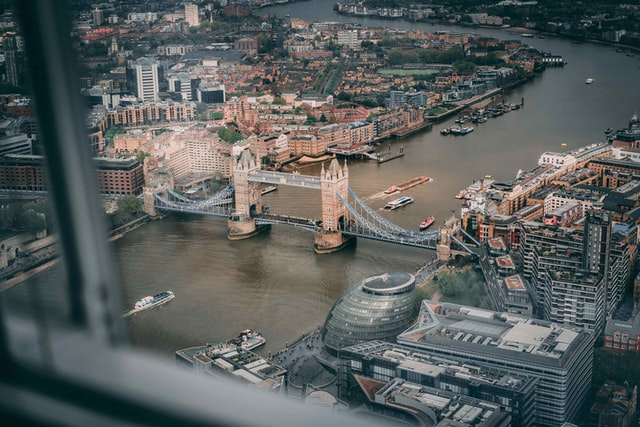

S3G8qX4Ft5s.jpg


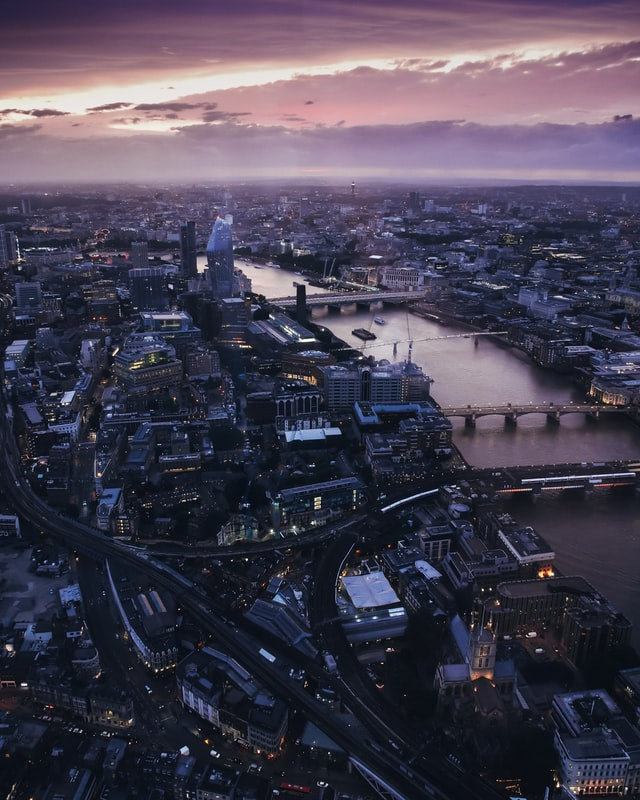

t05kfHeygbE.jpg


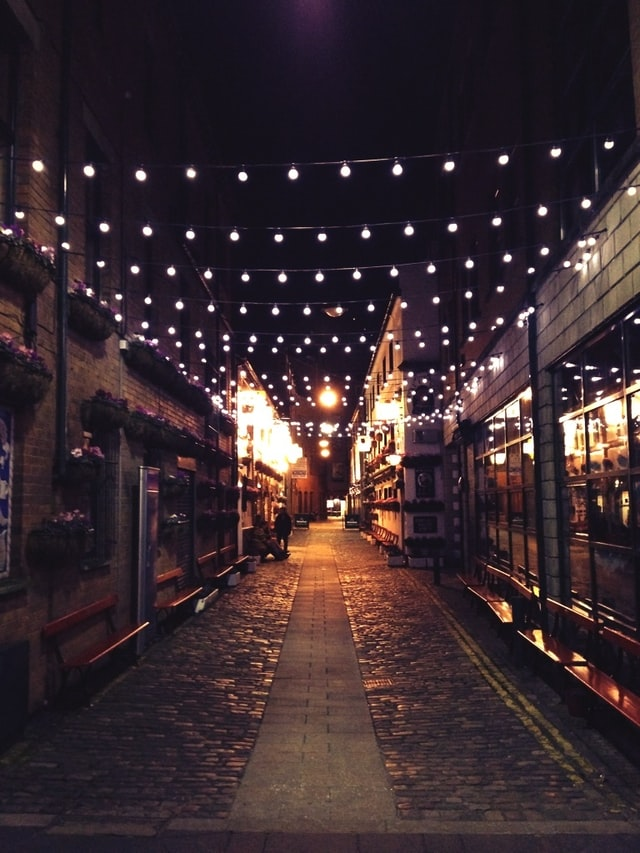

In [7]:
search("London")

Query:


'A dog in a park'

IVyZrLp41D0.jpg


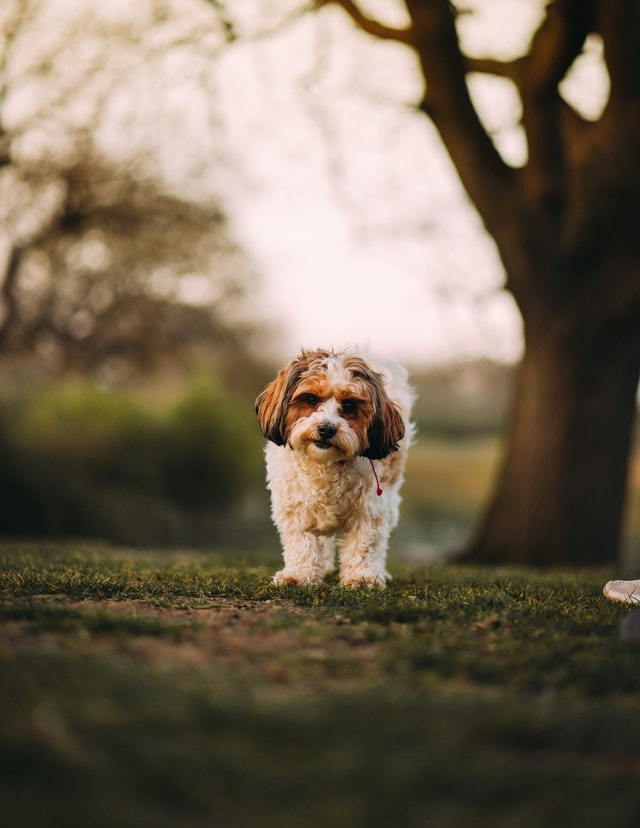

0O9A0F_d1qA.jpg


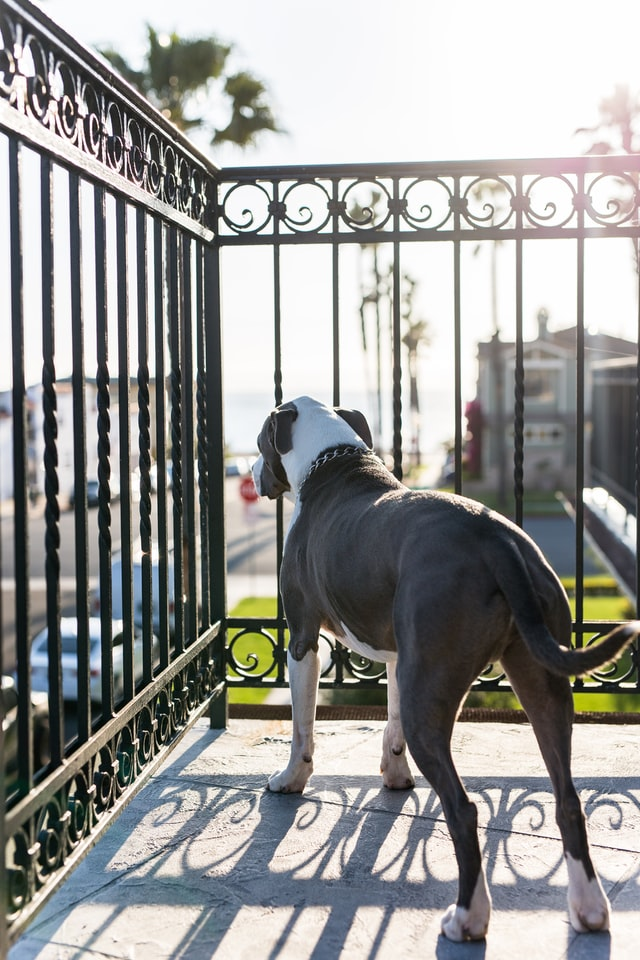

KVeogBZzl4M.jpg


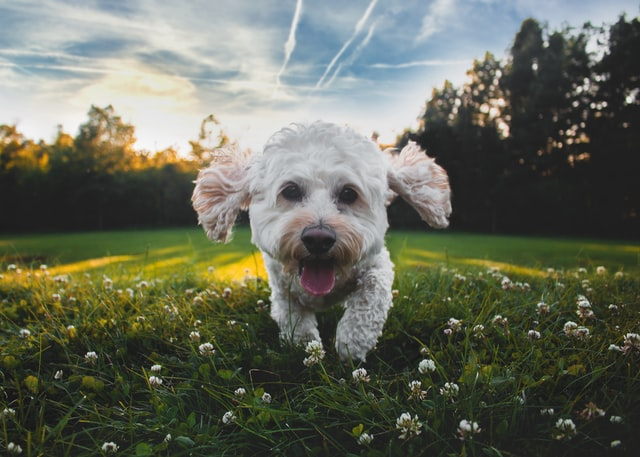

In [8]:
search("A dog in a park")

Query:


'A beach with palm trees'

7rrgPPljqYU.jpg


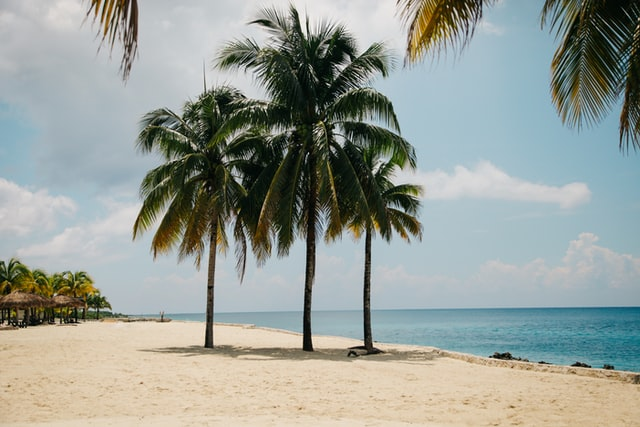

kmihWgpbDEg.jpg


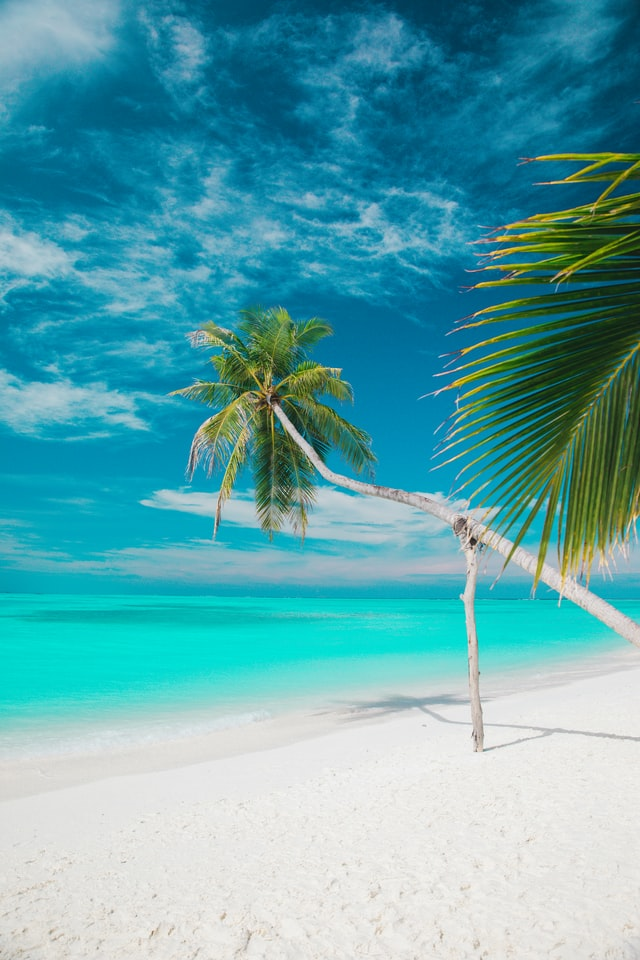

ZyfOq52b0cs.jpg


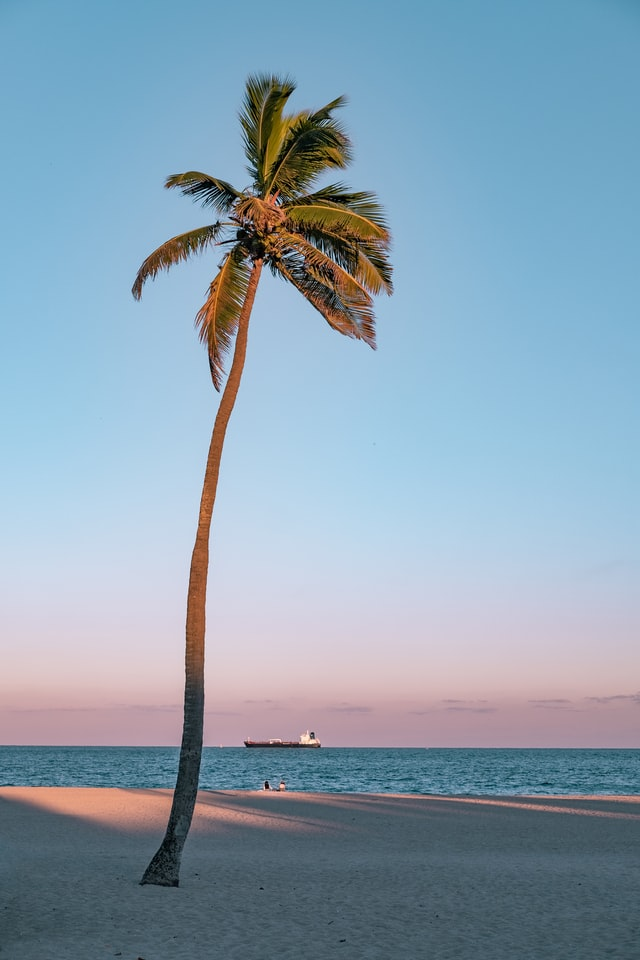

In [9]:
search("A beach with palm trees")

# Image-to-Image Search
You can use the method also for image-to-image search.

To achieve this, you pass `Image.open('path/to/image.jpg')` to the search method.

It will then return similar images

Query:


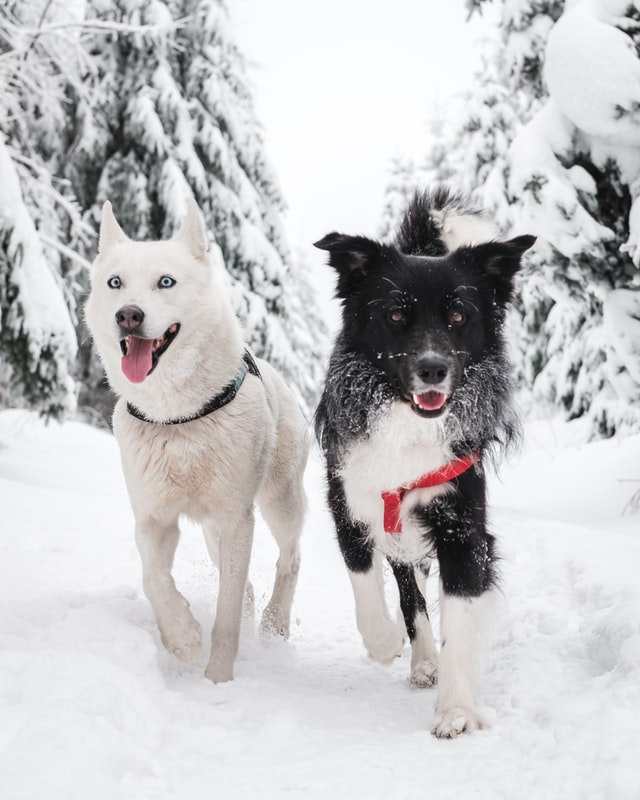

lyStEjlKNSw.jpg


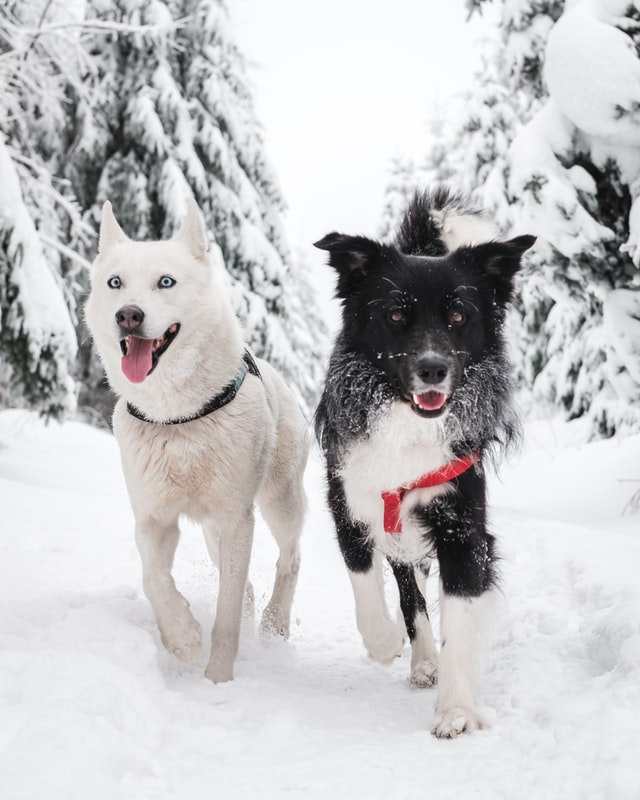

8rmYDezMIE4.jpg


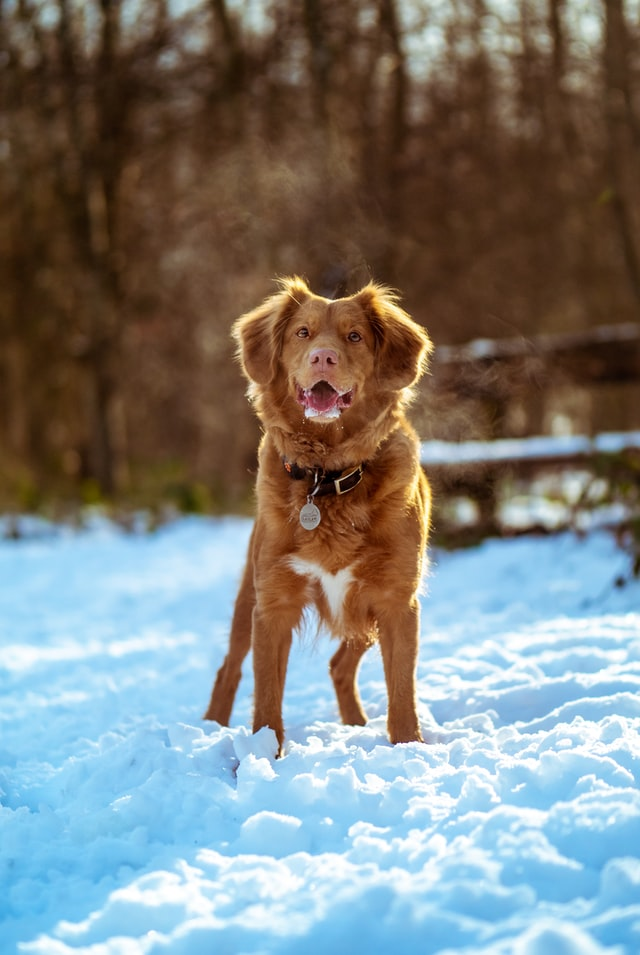

mMj5ykKvwAk.jpg


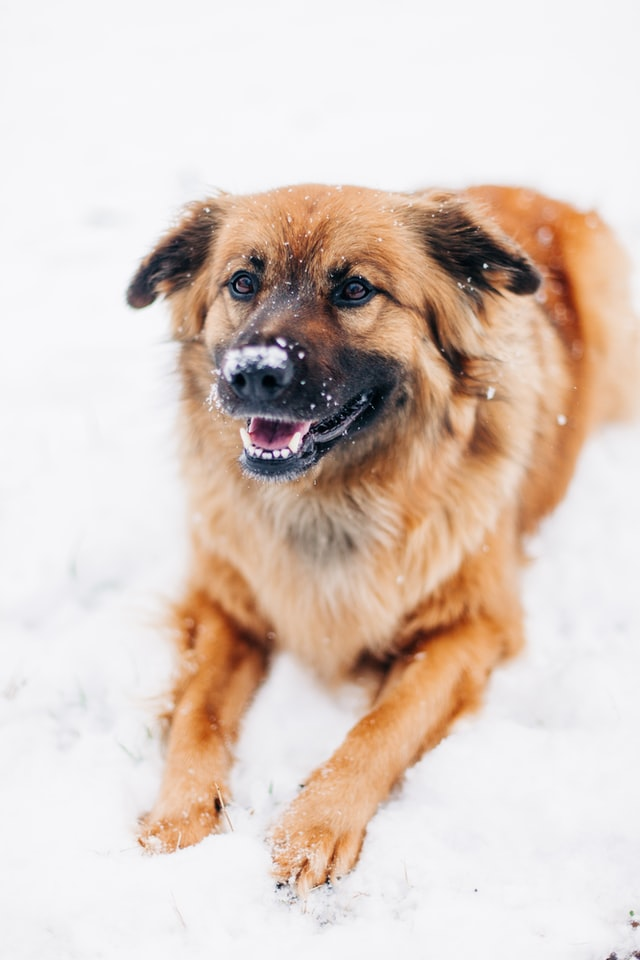

Ikge1ZIk9yc.jpg


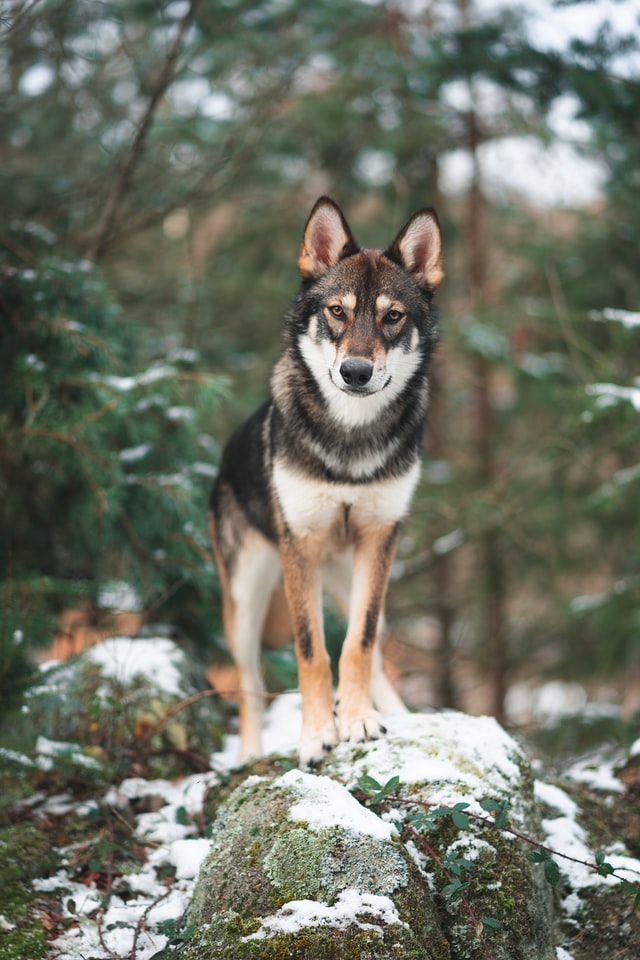

Xmo004TUzrI.jpg


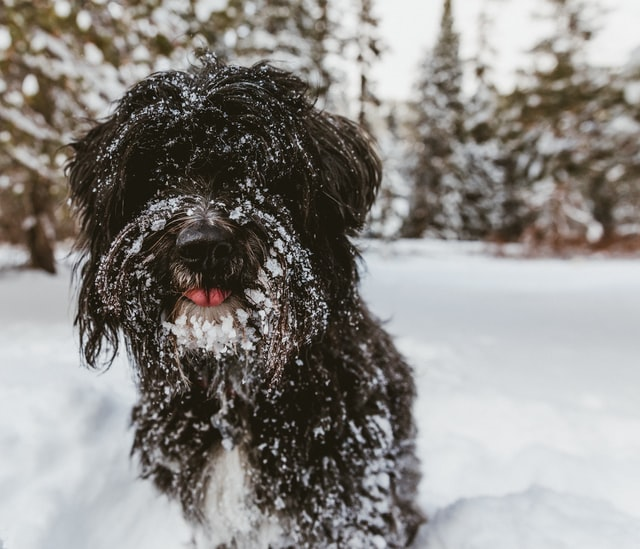

In [10]:
search(Image.open(os.path.join(img_folder, 'lyStEjlKNSw.jpg')), k=5)